In [1]:
#Rasterfairy
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE


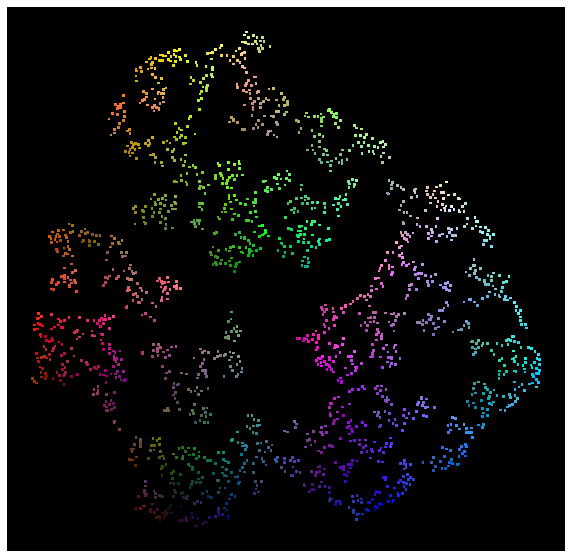

In [2]:
# generate a set of 4900 random 3D points
totalDataPoints = 2000 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D (we have to clone the array since bh_sne changes the original data)
# The bh_sne repository can be found here: https://github.com/danielfrg/tsne
#xy = bh_sne(dataPoints.copy())

xy = TSNE().fit_transform(dataPoints)


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()

In [ ]:
from rasterfairy import coonswarp

targetGrid = coonswarp.rectifyCloud(xy,perimeterSubdivisionSteps=4,autoPerimeterOffset=False, paddingScale=1.05)

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(targetGrid[:,0],targetGrid[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()

In [4]:
import rasterfairy
from rasterfairy import coonswarp
arrangements = rasterfairy.getRectArrangements(totalDataPoints)
sourceGrid = coonswarp.getCloudGrid( xy, perimeterSubdivisionSteps=4,autoPerimeterOffset=False, perimeterOffset=64,paddingScale=1.05, smoothing = 0.5)
#targetGrid =  coonswarp.rectifyCloud(xy,perimeterSubdivisionSteps=4,autoPerimeterOffset=False, paddingScale=1.05)
targetGrid, (width, height) = rasterfairy.transformPointCloud2D(xy,target=arrangements[0])
warped_xy  = coonswarp.warpCloud(xy,xy,targetGrid)

In [5]:
import io
from moviepy.editor import *
import PIL.Image as PImage
from IPython.display import clear_output, Image
from sklearn.cluster import KMeans

pointCount = len(xy)
gridPointCount = len(sourceGrid)
# some color reduction since the NeuQuant color reduction of images2gif does a bad job in this case:
kmeans = KMeans(n_clusters=min(255,pointCount), random_state=0).fit(dataPoints)
reducedColors = kmeans.cluster_centers_[kmeans.predict(dataPoints)]

width = 64
height = 64

images = []

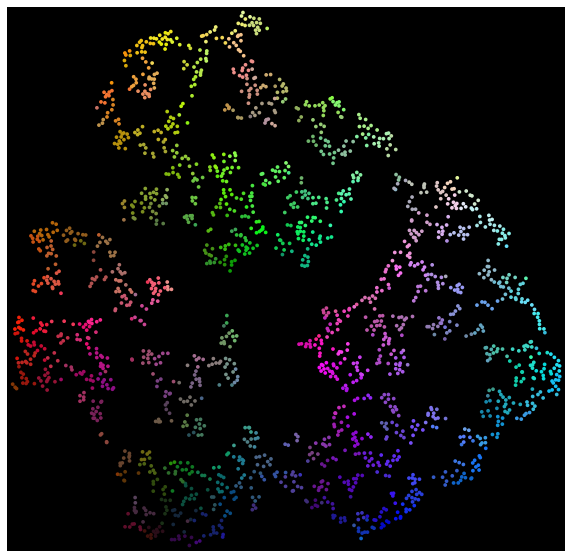

t:   2%|▏         | 2/101 [00:00<00:07, 13.37it/s, now=None]

MoviePy - Building file ../rf_transform_demo.gif with imageio.


In [6]:
# a bit of coordinate normalization so the coordinates are in the same range:
px_from = xy[:,0] - min(xy[:,0])
py_from = xy[:,1] - min(xy[:,1])

px_from /= max(px_from)
py_from /= max(py_from)

px_to = warped_xy[:,0] - min(warped_xy[:,0])
py_to = warped_xy[:,1] - min(warped_xy[:,1])

px_to /= max(px_to)
py_to /= max(py_to)

    
gx_from = sourceGrid[:,0] - min(sourceGrid[:,0])
gy_from = sourceGrid[:,1] - min(sourceGrid[:,1])

gx_from /= max(gx_from)
gy_from /= max(gy_from)

gx_to = targetGrid[:,0] - min(targetGrid[:,0])
gy_to = targetGrid[:,1] - min(targetGrid[:,1])

gx_to /= max(gx_to)
gy_to /= max(gy_to)


steps = 50

for i in range(steps*2):
    dx = []
    dy = []
    t = 1.0- abs(1.0 * i / (steps-1)-1.0) #tsteps[steps]
    for j in range( pointCount ):
        dx.append( (1.0-t)*px_from[j] + t*px_to[j])
        dy.append( (1.0-t)*py_from[j] + t*py_to[j] )
    
    fig2 = plt.figure(figsize=(10.0,10.0))
    ax = fig2.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.scatter(dx,dy, c = reducedColors,  edgecolors='none',s=14.0) #,marker='s'
    ax.axes.set_xlim([-0.01,1.01])
    ax.axes.set_ylim([-0.01,1.01])
    ax.invert_yaxis()
    clear_output(wait=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    images.append( np.array(PImage.open(buf)) )
    
    #in case you want to rather export a series of PNGs:
    #plt.savefig('clusters/cluster'+"%03d" % (i+steps,)+'.png')
    plt.show()
    
    
clip = ImageSequenceClip(images,fps=25)
clip.write_gif("../rf_transform_demo.gif")                 
Image(url="../rf_transform_demo.gif")